In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import transformers
from transformers import get_linear_schedule_with_warmup
from seqeval.metrics import f1_score, accuracy_score

# from transformers import BertTokenizer, BertConfig
# from transformers import BertForTokenClassification, AdamW

from transformers import RobertaConfig, RobertaModel
from transformers import RobertaTokenizer, RobertaForTokenClassification, AutoTokenizer, AdamW


2023-07-18 11:20:17.046435: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 11:20:17.566706: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Check GPU availability

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 Ti'

# **Preprocessing data**

In [3]:
# Reading data
import json


#open the file, and format correctly
f =open('dataset.jsonl', 'r')
json_object = json.dumps(f.readlines(), indent=4)
f.close()

#save better format into file
p = open('sample.txt', 'w')
for i in json_object:
    p.write(i)
p.close()

#open new file, and save each 
j = open('sample.txt', 'r')
text = json.loads(j.read())
j.close()

#compile all json dicts into a list
info = []
for i in text:
    info.append(json.loads(str(i)))
    

In [4]:
# To use the BERT, you must use the BERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/roberta-large-ner-english")


In [5]:
def degreekify(char):
    #char will be a character
    greek = {'α': '[alpha]', 'β':'[beta]', 'γ': '[gamma]', 'δ':'[delta]', 'ε': '[epsilon]', 'ζ':'[zeta]', 'η': '[eta]',
            'θ':'[theta]', 'ι': '[iota]', 'κ':'[kappa]', 'λ':'[lambda]', 'μ': '[mu]', 'ν':'[nu]', 'ξ':'[xi]', 'ο':'[omicron]', 'π':'[pi]', 'ρ':'[rho]',
            'σ': '[sigma]', 'τ': '[tau]', 'υ':'[upsilon]', 'φ':'[phi]', 'χ':'[chi]', 'ψ':'[psi]', 'ω':'[omega]' }
    if char in greek:
        return greek[char]
    else:
        return char

In [6]:
def pre_process(text, annotations):
    #text will be the straight sentence, info[i]['text']
    #annotations will be the list of labels, must be info[i]['annotations']
    
    text_dict = []
    
    for i in range(len(text)):
        text_dict.append(degreekify(text[i]))
    
    
    
    ann_indices = []
    def fun(x):
        return x['start_offset']
    annotations.sort(key=fun)
    
    
    
    if len(annotations)==0:
        ann_indices.append([[0, len(text)],0])
    else:
        ann_indices.append([[0, annotations[0]['start_offset']], 0])
        for i in range(len(annotations)-1):
            ann_indices.append([[annotations[i]['start_offset'], annotations[i]['end_offset']], annotations[i]['label']])
            ann_indices.append([[annotations[i]['end_offset'], annotations[i+1]['start_offset']], 0])
            
        ann_indices.append([[annotations[-1]['start_offset'], annotations[-1]['end_offset']], annotations[-1]['label']])
        ann_indices.append([[annotations[-1]['end_offset'], len(text)], 0])
         
    
    labels = []
    sentences = []
    for a in ann_indices:
        
        if a[0][1]-a[0][0] !=0:
            together = ''
            for i in range(a[0][0], a[0][1]):
                together += text_dict[i]
                
            toke = together.split()
            sentences.extend(toke)
            t = len(toke)
            if t != 0:
                temp = [data_tags[2 * a[1]]] * t
                if a[1] != 0:
                    temp[0] = data_tags[2 * a[1]-1]
                labels.extend(temp)
 
    return labels, sentences

In [7]:
#create labels
data_tags = ['0','C', 'C-cont' , 'M', 'M-cont', 'Q', 'Q-cont', 'T' , 'T-cont', 'A' , 'A-cont', 'R', 'R-cont']

sentences, labels = [], []

for i in range(len(info)):
    l,s = pre_process(info[i]['text'], info[i]['annotations'])
    if len(l) != len(s):
        print('fuck')
    else:
        labels.append(l)
        sentences.append(s)

In [8]:

for i in range(5):
    s, l = sentences[i], labels[i]
    if len(l) != len(s):
        print('fuck')
    else:
        for j in range(len(l)):
            print(l[j],s[j])
    

0 The
0 influence
0 of
R [gamma]-radiation
0 on
0 the
0 physical
0 characteristics
0 and
0 sorption
0 properties
0 for
M Am
0 of
0 the
0 solid
0 extractant
C AXIONIT
C-cont MND
C-cont 40T
0 (
C TVEX
0 )
0 synthesized
0 by
0 Axion-Rare
0 and
0 Noble
0 Metals
0 JSC
0 (Perm)
0 was
0 studied.
0 With
0 an
0 increase
0 of
0 the
0 absorbed
0 dose
0 of
R [gamma]-radiation
0 ,
0 the
0 granulometric
0 composition,
0 bulk
0 density,
0 and
0 specific
0 volume
0 of
C TVEX
0 change
0 insignificantly.
0 The
0 IR
0 spectra
0 of
C TVEX
0 demonstrate
0 significant
0 radiation
0 degradation
0 at
0 an
0 absorbed
0 radiation
0 dose
0 from
Q 1.4
Q-cont to
Q-cont 2.5
Q-cont MGy
0 .
C TVEX
0 is
0 an
0 effective
M Am
0 sorbent
0 when
0 irradiated
0 to
0 an
0 absorbed
R [gamma]-radiation
0 dose
0 of
0 no
0 more
0 than
Q 0.6
Q-cont MGy
0 .
0 At
0 an
0 irradiation
0 dose
0 of
Q 2.5
Q-cont MGy
0 sorption
0 capacity
0 is
0 significantly
0 reduced.
0 Basic
0 physicochemical
0 properties
0 of
0 the
C TVEX
0 sample
0 

In [9]:

# Determine the list of tags
tag_values = data_tags
print(tag_values)

tag_values.append("PAD")
print(tag_values)

tag2idx = {t: i for i, t in enumerate(tag_values)}
print(tag2idx)
     

['0', 'C', 'C-cont', 'M', 'M-cont', 'Q', 'Q-cont', 'T', 'T-cont', 'A', 'A-cont', 'R', 'R-cont']
['0', 'C', 'C-cont', 'M', 'M-cont', 'Q', 'Q-cont', 'T', 'T-cont', 'A', 'A-cont', 'R', 'R-cont', 'PAD']
{'0': 0, 'C': 1, 'C-cont': 2, 'M': 3, 'M-cont': 4, 'Q': 5, 'Q-cont': 6, 'T': 7, 'T-cont': 8, 'A': 9, 'A-cont': 10, 'R': 11, 'R-cont': 12, 'PAD': 13}


In [10]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [11]:
tokenized_texts_and_labels = [ tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels)]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [12]:
# MAX_LEN is the maximum length of a sequence
MAX_LEN = 128 # 64 or 128 or ...
bs = 6 # batch size


In [13]:
# Use Padding to equalize the length of sentences
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
     

In [14]:
# Do not mask values that are zero
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [15]:
# Split data to train and validation. %90 for train and %10 for validation
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)

# Each mask contains 10% of a sentence
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# The input of the BERT should be the tensors produced using PyTorch
# So convert all inputs and labels into torch tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)

tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

# Create the DataLoader for our training set
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

print(train_sampler)

# Create the DataLoader for our validation set
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


# **Build model**

In [16]:
# Load RoBERTa Model
from transformers import AutoTokenizer, AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained(
    "roberta-base",
    num_labels=len(tag2idx), # The number of output labels
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
    
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions

In [17]:
# Tell PyTorch to run this model on the GPU
model.cuda();

In [18]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr= 2e-6, # learning-rate default is 3e-5
    eps=1e-8 # adam-epsilon default is 1e-8
)


/home/ecasey/anaconda3/envs/torch/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
epochs = 150

max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=30,
    num_training_steps=total_steps
)

# **Training**

In [30]:
def acc(print_labels, special):
    accuracy_list = []
    max_a = 0
    index_a = 1000000
    
    for i in range(len(sentences)):
       
        temp = []
        for j in range(len(sentences[i])):
            temp.extend(tokenizer.tokenize(sentences[i][j]))
        
        temp1 = []
     
        for j in range(len(temp)):
            t = tokenizer.convert_tokens_to_ids(temp[j])
            temp1.append(t)
            
        tokenized_sentence = temp1
        input_ids = torch.tensor([tokenized_sentence]).cuda()

        with torch.no_grad():
            output = model(input_ids)

        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

        # join bpe split tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(tag_values[label_idx])
                new_tokens.append(token)

        new_labels = new_labels[1:-1]
        a = accuracy_score(new_labels, labels[i])
        if a  >= max_a and i !=4:
            max_a = a
            index_a = i
          
        accuracy_list.append(a)
        if print_labels == True:
            print("___________________"+ str(i)+"___________________")
            print("\nPredict labels: ",new_labels)
            print("Actual labels: ",labels[i])
            print()
            print()
            if special == i:
                for j in range(len(sentences[i])):
                    print(sentences[i][j], new_labels[j])
    print(index_a, max_a)
    return statistics.mean(accuracy_list)
        


In [21]:
## Store the average loss after each epoch so we can plot them.
import copy
loss_values, validation_loss_values = [], []

test_acc = []

max_test = 10

for e in trange(epochs, desc="Epoch"):
    
    
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("\nAverage train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("\nValidation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    #print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()
    a = eval_loss
    test_acc.append(a)
    if a <= max_test:
        max_test = a
    elif a * 1.2 == max_test:
        f = open("text.ck", "w")
        torch.save(model, "test.ck")
        f.close()

Epoch:   1%|▌                                                                                        | 1/150 [00:02<05:08,  2.07s/it]


Average train loss: 2.568579969406128

Validation loss: 2.4837438265482583
Validation Accuracy: 0.22230889235569423



Epoch:   1%|█▏                                                                                       | 2/150 [00:03<04:28,  1.81s/it]


Average train loss: 2.3340539169311523

Validation loss: 2.18564772605896
Validation Accuracy: 0.6794071762870515



Epoch:   2%|█▊                                                                                       | 3/150 [00:05<04:14,  1.73s/it]


Average train loss: 1.8972214937210083

Validation loss: 1.712647835413615
Validation Accuracy: 0.6786271450858035



Epoch:   3%|██▎                                                                                      | 4/150 [00:06<04:07,  1.70s/it]


Average train loss: 1.4212381362915039

Validation loss: 1.1120134790738423
Validation Accuracy: 0.6489859594383776



Epoch:   3%|██▉                                                                                      | 5/150 [00:08<04:02,  1.67s/it]


Average train loss: 1.0183690094947815

Validation loss: 0.7102320591608683
Validation Accuracy: 0.6482059282371295



Epoch:   4%|███▌                                                                                     | 6/150 [00:10<03:59,  1.66s/it]


Average train loss: 0.8010900235176086

Validation loss: 0.5983279347419739
Validation Accuracy: 0.6864274570982839



Epoch:   5%|████▏                                                                                    | 7/150 [00:11<03:56,  1.65s/it]


Average train loss: 0.6852968513965607

Validation loss: 0.5211707651615143
Validation Accuracy: 0.7636505460218409



Epoch:   5%|████▋                                                                                    | 8/150 [00:13<03:54,  1.65s/it]


Average train loss: 0.5804267930984497

Validation loss: 0.45453078548113507
Validation Accuracy: 0.7940717628705148



Epoch:   6%|█████▎                                                                                   | 9/150 [00:15<03:52,  1.65s/it]


Average train loss: 0.5355248117446899

Validation loss: 0.4099598328272502
Validation Accuracy: 0.8073322932917316



Epoch:   7%|█████▊                                                                                  | 10/150 [00:16<03:50,  1.65s/it]


Average train loss: 0.4498290014266968

Validation loss: 0.3763286719719569
Validation Accuracy: 0.8120124804992199



Epoch:   7%|██████▍                                                                                 | 11/150 [00:18<03:48,  1.65s/it]


Average train loss: 0.4193257701396942

Validation loss: 0.3521505494912465
Validation Accuracy: 0.8198127925117005



Epoch:   8%|███████                                                                                 | 12/150 [00:20<03:46,  1.64s/it]


Average train loss: 0.4085522383451462

Validation loss: 0.3285818099975586
Validation Accuracy: 0.8369734789391575



Epoch:   9%|███████▋                                                                                | 13/150 [00:21<03:45,  1.64s/it]


Average train loss: 0.3562753856182098

Validation loss: 0.3118108759323756
Validation Accuracy: 0.8416536661466458



Epoch:   9%|████████▏                                                                               | 14/150 [00:23<03:43,  1.64s/it]


Average train loss: 0.3484062159061432

Validation loss: 0.2950112372636795
Validation Accuracy: 0.8564742589703588



Epoch:  10%|████████▊                                                                               | 15/150 [00:25<03:41,  1.64s/it]


Average train loss: 0.35179773151874544

Validation loss: 0.2843092729647954
Validation Accuracy: 0.858034321372855



Epoch:  11%|█████████▍                                                                              | 16/150 [00:26<03:40,  1.64s/it]


Average train loss: 0.3053028601408005

Validation loss: 0.27333658436934155
Validation Accuracy: 0.858034321372855



Epoch:  11%|█████████▉                                                                              | 17/150 [00:28<03:38,  1.64s/it]


Average train loss: 0.29593505650758745

Validation loss: 0.26667584975560504
Validation Accuracy: 0.859594383775351



Epoch:  12%|██████████▌                                                                             | 18/150 [00:29<03:37,  1.64s/it]


Average train loss: 0.2807025623321533

Validation loss: 0.25992659231026966
Validation Accuracy: 0.8619344773790951



Epoch:  13%|███████████▏                                                                            | 19/150 [00:31<03:35,  1.65s/it]


Average train loss: 0.27387726098299026

Validation loss: 0.25670064489046734
Validation Accuracy: 0.8627145085803433



Epoch:  13%|███████████▋                                                                            | 20/150 [00:33<03:34,  1.65s/it]


Average train loss: 0.25335166960954664

Validation loss: 0.2466250086824099
Validation Accuracy: 0.8666146645865834



Epoch:  14%|████████████▎                                                                           | 21/150 [00:34<03:31,  1.64s/it]


Average train loss: 0.2517577451467514

Validation loss: 0.23815766225258508
Validation Accuracy: 0.8705148205928237



Epoch:  15%|████████████▉                                                                           | 22/150 [00:36<03:29,  1.64s/it]


Average train loss: 0.2535327351093292

Validation loss: 0.23514583458503088
Validation Accuracy: 0.8697347893915757



Epoch:  15%|█████████████▍                                                                          | 23/150 [00:38<03:27,  1.63s/it]


Average train loss: 0.23653726220130922

Validation loss: 0.23091437170902887
Validation Accuracy: 0.8705148205928237



Epoch:  16%|██████████████                                                                          | 24/150 [00:39<03:25,  1.63s/it]


Average train loss: 0.22713248789310456

Validation loss: 0.22790576765934625
Validation Accuracy: 0.8728549141965679



Epoch:  17%|██████████████▋                                                                         | 25/150 [00:41<03:23,  1.63s/it]


Average train loss: 0.21788596987724304

Validation loss: 0.22360478093226752
Validation Accuracy: 0.8767550702028081



Epoch:  17%|███████████████▎                                                                        | 26/150 [00:43<03:21,  1.63s/it]


Average train loss: 0.2071676644682884

Validation loss: 0.21607442696889242
Validation Accuracy: 0.8814352574102964



Epoch:  18%|███████████████▊                                                                        | 27/150 [00:44<03:20,  1.63s/it]


Average train loss: 0.21405773967504502

Validation loss: 0.2199520394206047
Validation Accuracy: 0.8806552262090483



Epoch:  19%|████████████████▍                                                                       | 28/150 [00:46<03:19,  1.64s/it]


Average train loss: 0.2016009745001793

Validation loss: 0.219886414706707
Validation Accuracy: 0.8790951638065523



Epoch:  19%|█████████████████                                                                       | 29/150 [00:47<03:18,  1.64s/it]


Average train loss: 0.18940951377153398

Validation loss: 0.21269793808460236
Validation Accuracy: 0.8853354134165367



Epoch:  20%|█████████████████▌                                                                      | 30/150 [00:49<03:17,  1.65s/it]


Average train loss: 0.17736027419567107

Validation loss: 0.21327281246582666
Validation Accuracy: 0.8853354134165367



Epoch:  21%|██████████████████▏                                                                     | 31/150 [00:51<03:16,  1.65s/it]


Average train loss: 0.17910895079374314

Validation loss: 0.2098736191789309
Validation Accuracy: 0.8861154446177847



Epoch:  21%|██████████████████▊                                                                     | 32/150 [00:52<03:14,  1.65s/it]


Average train loss: 0.1862320140004158

Validation loss: 0.20529203365246454
Validation Accuracy: 0.8884555382215289



Epoch:  22%|███████████████████▎                                                                    | 33/150 [00:54<03:13,  1.65s/it]


Average train loss: 0.16083523571491243

Validation loss: 0.20766281833251318
Validation Accuracy: 0.8892355694227769



Epoch:  23%|███████████████████▉                                                                    | 34/150 [00:56<03:11,  1.65s/it]


Average train loss: 0.16365471303462983

Validation loss: 0.20182796319325766
Validation Accuracy: 0.890795631825273



Epoch:  23%|████████████████████▌                                                                   | 35/150 [00:57<03:09,  1.65s/it]


Average train loss: 0.15949222713708877

Validation loss: 0.20148521413405737
Validation Accuracy: 0.890015600624025



Epoch:  24%|█████████████████████                                                                   | 36/150 [00:59<03:08,  1.65s/it]


Average train loss: 0.1489245080947876

Validation loss: 0.20352348188559213
Validation Accuracy: 0.8931357254290172



Epoch:  25%|█████████████████████▋                                                                  | 37/150 [01:01<03:06,  1.65s/it]


Average train loss: 0.14700980186462403

Validation loss: 0.19829141100247702
Validation Accuracy: 0.8970358814352574



Epoch:  25%|██████████████████████▎                                                                 | 38/150 [01:02<03:05,  1.65s/it]


Average train loss: 0.1397753168642521

Validation loss: 0.20534949253002802
Validation Accuracy: 0.8985959438377535



Epoch:  26%|██████████████████████▉                                                                 | 39/150 [01:04<03:03,  1.65s/it]


Average train loss: 0.13218694016337396

Validation loss: 0.20251909146706262
Validation Accuracy: 0.8970358814352574



Epoch:  27%|███████████████████████▍                                                                | 40/150 [01:06<03:01,  1.65s/it]


Average train loss: 0.13713517531752586

Validation loss: 0.19190985833605131
Validation Accuracy: 0.8978159126365055



Epoch:  27%|████████████████████████                                                                | 41/150 [01:07<03:00,  1.66s/it]


Average train loss: 0.13119914323091508

Validation loss: 0.20330577964584032
Validation Accuracy: 0.9009360374414976



Epoch:  28%|████████████████████████▋                                                               | 42/150 [01:09<02:58,  1.66s/it]


Average train loss: 0.12991786137223243

Validation loss: 0.19696017603079477
Validation Accuracy: 0.8993759750390016



Epoch:  29%|█████████████████████████▏                                                              | 43/150 [01:11<02:57,  1.66s/it]


Average train loss: 0.1185625983774662

Validation loss: 0.19281881426771483
Validation Accuracy: 0.9040561622464899



Epoch:  29%|█████████████████████████▊                                                              | 44/150 [01:12<02:55,  1.66s/it]


Average train loss: 0.11987092092633247

Validation loss: 0.20388724903265634
Validation Accuracy: 0.9017160686427457



Epoch:  30%|██████████████████████████▍                                                             | 45/150 [01:14<02:53,  1.65s/it]


Average train loss: 0.12664378091692924

Validation loss: 0.19849182044466337
Validation Accuracy: 0.9024960998439937



Epoch:  31%|██████████████████████████▉                                                             | 46/150 [01:16<02:51,  1.65s/it]


Average train loss: 0.11926700994372368

Validation loss: 0.19953880086541176
Validation Accuracy: 0.905616224648986



Epoch:  31%|███████████████████████████▌                                                            | 47/150 [01:17<02:49,  1.64s/it]


Average train loss: 0.10440577387809753

Validation loss: 0.1935324321190516
Validation Accuracy: 0.9024960998439937



Epoch:  32%|████████████████████████████▏                                                           | 48/150 [01:19<02:47,  1.64s/it]


Average train loss: 0.10083743296563626

Validation loss: 0.20196696246663728
Validation Accuracy: 0.905616224648986



Epoch:  33%|████████████████████████████▋                                                           | 49/150 [01:20<02:46,  1.65s/it]


Average train loss: 0.10174088209867477

Validation loss: 0.20062029361724854
Validation Accuracy: 0.9024960998439937



Epoch:  33%|█████████████████████████████▎                                                          | 50/150 [01:22<02:44,  1.65s/it]


Average train loss: 0.10029292330145836

Validation loss: 0.20294109483559927
Validation Accuracy: 0.9024960998439937



Epoch:  34%|█████████████████████████████▉                                                          | 51/150 [01:24<02:43,  1.65s/it]


Average train loss: 0.09450397104024887

Validation loss: 0.20484714085857073
Validation Accuracy: 0.906396255850234



Epoch:  35%|██████████████████████████████▌                                                         | 52/150 [01:25<02:42,  1.65s/it]


Average train loss: 0.09276459768414497

Validation loss: 0.20744608342647552
Validation Accuracy: 0.905616224648986



Epoch:  35%|███████████████████████████████                                                         | 53/150 [01:27<02:39,  1.65s/it]


Average train loss: 0.08923893675208092

Validation loss: 0.20180545623103777
Validation Accuracy: 0.907176287051482



Epoch:  36%|███████████████████████████████▋                                                        | 54/150 [01:29<02:38,  1.65s/it]


Average train loss: 0.08362676501274109

Validation loss: 0.20858214298884073
Validation Accuracy: 0.905616224648986



Epoch:  37%|████████████████████████████████▎                                                       | 55/150 [01:30<02:37,  1.66s/it]


Average train loss: 0.07966637436300517

Validation loss: 0.2077267368634542
Validation Accuracy: 0.9040561622464899



Epoch:  37%|████████████████████████████████▊                                                       | 56/150 [01:32<02:35,  1.66s/it]


Average train loss: 0.08093541711568833

Validation loss: 0.2043374925851822
Validation Accuracy: 0.906396255850234



Epoch:  38%|█████████████████████████████████▍                                                      | 57/150 [01:34<02:34,  1.66s/it]


Average train loss: 0.07841725096106529

Validation loss: 0.21389401083191237
Validation Accuracy: 0.9040561622464899



Epoch:  39%|██████████████████████████████████                                                      | 58/150 [01:35<02:32,  1.66s/it]


Average train loss: 0.08765316352248192

Validation loss: 0.20425856734315553
Validation Accuracy: 0.9040561622464899



Epoch:  39%|██████████████████████████████████▌                                                     | 59/150 [01:37<02:30,  1.65s/it]


Average train loss: 0.07530159575864673

Validation loss: 0.20869820937514305
Validation Accuracy: 0.9079563182527302



Epoch:  40%|███████████████████████████████████▏                                                    | 60/150 [01:39<02:28,  1.65s/it]


Average train loss: 0.07294592775404453

Validation loss: 0.20826105400919914
Validation Accuracy: 0.907176287051482



Epoch:  41%|███████████████████████████████████▊                                                    | 61/150 [01:40<02:26,  1.65s/it]


Average train loss: 0.07362632751464844

Validation loss: 0.2066142645974954
Validation Accuracy: 0.907176287051482



Epoch:  41%|████████████████████████████████████▎                                                   | 62/150 [01:42<02:25,  1.65s/it]


Average train loss: 0.07065585374832153

Validation loss: 0.21304520592093468
Validation Accuracy: 0.9032761310452418



Epoch:  42%|████████████████████████████████████▉                                                   | 63/150 [01:44<02:24,  1.66s/it]


Average train loss: 0.0702388546615839

Validation loss: 0.2173494944969813
Validation Accuracy: 0.9048361934477379



Epoch:  43%|█████████████████████████████████████▌                                                  | 64/150 [01:45<02:22,  1.66s/it]


Average train loss: 0.06498955316841602

Validation loss: 0.21539530530571938
Validation Accuracy: 0.9087363494539782



Epoch:  43%|██████████████████████████████████████▏                                                 | 65/150 [01:47<02:20,  1.66s/it]


Average train loss: 0.07025626748800277

Validation loss: 0.20966567719976106
Validation Accuracy: 0.9079563182527302



Epoch:  44%|██████████████████████████████████████▋                                                 | 66/150 [01:49<02:19,  1.66s/it]


Average train loss: 0.06586458057165145

Validation loss: 0.21376967802643776
Validation Accuracy: 0.907176287051482



Epoch:  45%|███████████████████████████████████████▎                                                | 67/150 [01:50<02:17,  1.66s/it]


Average train loss: 0.059423273354768755

Validation loss: 0.2149669515589873
Validation Accuracy: 0.905616224648986



Epoch:  45%|███████████████████████████████████████▉                                                | 68/150 [01:52<02:16,  1.66s/it]


Average train loss: 0.0591089641302824

Validation loss: 0.20670099183917046
Validation Accuracy: 0.9040561622464899



Epoch:  46%|████████████████████████████████████████▍                                               | 69/150 [01:54<02:14,  1.66s/it]


Average train loss: 0.05907054603099823

Validation loss: 0.21197473630309105
Validation Accuracy: 0.9095163806552262



Epoch:  47%|█████████████████████████████████████████                                               | 70/150 [01:55<02:13,  1.66s/it]


Average train loss: 0.057102442532777783

Validation loss: 0.210310826698939
Validation Accuracy: 0.9040561622464899



Epoch:  47%|█████████████████████████████████████████▋                                              | 71/150 [01:57<02:11,  1.66s/it]


Average train loss: 0.05714770779013634

Validation loss: 0.2187103865047296
Validation Accuracy: 0.9110764430577223



Epoch:  48%|██████████████████████████████████████████▏                                             | 72/150 [01:59<02:09,  1.66s/it]


Average train loss: 0.05645892456173897

Validation loss: 0.21238703529040018
Validation Accuracy: 0.9102964118564743



Epoch:  49%|██████████████████████████████████████████▊                                             | 73/150 [02:00<02:07,  1.66s/it]


Average train loss: 0.055974969267845155

Validation loss: 0.2110717880229155
Validation Accuracy: 0.9095163806552262



Epoch:  49%|███████████████████████████████████████████▍                                            | 74/150 [02:02<02:06,  1.66s/it]


Average train loss: 0.05156603153795004

Validation loss: 0.2111283876001835
Validation Accuracy: 0.9110764430577223



Epoch:  50%|████████████████████████████████████████████                                            | 75/150 [02:04<02:04,  1.66s/it]


Average train loss: 0.05290477767586708

Validation loss: 0.21616563325126967
Validation Accuracy: 0.9110764430577223



Epoch:  51%|████████████████████████████████████████████▌                                           | 76/150 [02:05<02:02,  1.66s/it]


Average train loss: 0.051507211551070214

Validation loss: 0.20395345985889435
Validation Accuracy: 0.9165366614664586



Epoch:  51%|█████████████████████████████████████████████▏                                          | 77/150 [02:07<02:01,  1.66s/it]


Average train loss: 0.04950835831463337

Validation loss: 0.21488705401619276
Validation Accuracy: 0.9141965678627145



Epoch:  52%|█████████████████████████████████████████████▊                                          | 78/150 [02:09<01:59,  1.66s/it]


Average train loss: 0.04688521638512611

Validation loss: 0.21440330147743225
Validation Accuracy: 0.9134165366614665



Epoch:  53%|██████████████████████████████████████████████▎                                         | 79/150 [02:10<01:57,  1.66s/it]


Average train loss: 0.04710272656753659

Validation loss: 0.21794814243912697
Validation Accuracy: 0.9165366614664586



Epoch:  53%|██████████████████████████████████████████████▉                                         | 80/150 [02:12<01:56,  1.66s/it]


Average train loss: 0.04846114654093981

Validation loss: 0.2136292407910029
Validation Accuracy: 0.9141965678627145



Epoch:  54%|███████████████████████████████████████████████▌                                        | 81/150 [02:14<01:54,  1.66s/it]


Average train loss: 0.04596616003662348

Validation loss: 0.2141840656598409
Validation Accuracy: 0.9157566302652106



Epoch:  55%|████████████████████████████████████████████████                                        | 82/150 [02:15<01:52,  1.65s/it]


Average train loss: 0.0429985960572958

Validation loss: 0.21814454471071562
Validation Accuracy: 0.9134165366614665



Epoch:  55%|████████████████████████████████████████████████▋                                       | 83/150 [02:17<01:51,  1.66s/it]


Average train loss: 0.043907771818339825

Validation loss: 0.21624177197615305
Validation Accuracy: 0.9126365054602185



Epoch:  56%|█████████████████████████████████████████████████▎                                      | 84/150 [02:19<01:49,  1.66s/it]


Average train loss: 0.04246813915669918

Validation loss: 0.21629189824064574
Validation Accuracy: 0.9149765990639626



Epoch:  57%|█████████████████████████████████████████████████▊                                      | 85/150 [02:20<01:47,  1.66s/it]


Average train loss: 0.04466436561197042

Validation loss: 0.22391692300637564
Validation Accuracy: 0.9149765990639626



Epoch:  57%|██████████████████████████████████████████████████▍                                     | 86/150 [02:22<01:45,  1.66s/it]


Average train loss: 0.04404762901365757

Validation loss: 0.21560335780183473
Validation Accuracy: 0.9180967238689548



Epoch:  58%|███████████████████████████████████████████████████                                     | 87/150 [02:23<01:44,  1.65s/it]


Average train loss: 0.04024875160306692

Validation loss: 0.22262064988414446
Validation Accuracy: 0.9173166926677067



Epoch:  59%|███████████████████████████████████████████████████▋                                    | 88/150 [02:25<01:42,  1.65s/it]


Average train loss: 0.04030821157619357

Validation loss: 0.21696936587492624
Validation Accuracy: 0.9188767550702028



Epoch:  59%|████████████████████████████████████████████████████▏                                   | 89/150 [02:27<01:40,  1.65s/it]


Average train loss: 0.03841540418565273

Validation loss: 0.21790645147363344
Validation Accuracy: 0.9173166926677067



Epoch:  60%|████████████████████████████████████████████████████▊                                   | 90/150 [02:28<01:39,  1.65s/it]


Average train loss: 0.03883328683674336

Validation loss: 0.2241304119427999
Validation Accuracy: 0.9180967238689548



Epoch:  61%|█████████████████████████████████████████████████████▍                                  | 91/150 [02:30<01:37,  1.66s/it]


Average train loss: 0.039031713046133516

Validation loss: 0.22265530501802763
Validation Accuracy: 0.9188767550702028



Epoch:  61%|█████████████████████████████████████████████████████▉                                  | 92/150 [02:32<01:36,  1.66s/it]


Average train loss: 0.038293396458029746

Validation loss: 0.21950344617168108
Validation Accuracy: 0.9165366614664586



Epoch:  62%|██████████████████████████████████████████████████████▌                                 | 93/150 [02:33<01:34,  1.66s/it]


Average train loss: 0.03633377956226468

Validation loss: 0.22998210166891417
Validation Accuracy: 0.9180967238689548



Epoch:  63%|███████████████████████████████████████████████████████▏                                | 94/150 [02:35<01:33,  1.66s/it]


Average train loss: 0.03510768122971058

Validation loss: 0.22259646281599998
Validation Accuracy: 0.9188767550702028



Epoch:  63%|███████████████████████████████████████████████████████▋                                | 95/150 [02:37<01:31,  1.66s/it]


Average train loss: 0.035575650185346606

Validation loss: 0.2215599206586679
Validation Accuracy: 0.9204368174726989



Epoch:  64%|████████████████████████████████████████████████████████▎                               | 96/150 [02:38<01:29,  1.66s/it]


Average train loss: 0.034345246478915216

Validation loss: 0.22365787252783775
Validation Accuracy: 0.9196567862714509



Epoch:  65%|████████████████████████████████████████████████████████▉                               | 97/150 [02:40<01:28,  1.66s/it]


Average train loss: 0.03265205178409815

Validation loss: 0.22081087032953897
Validation Accuracy: 0.9157566302652106



Epoch:  65%|█████████████████████████████████████████████████████████▍                              | 98/150 [02:42<01:26,  1.66s/it]


Average train loss: 0.03442514255642891

Validation loss: 0.2181419382492701
Validation Accuracy: 0.9180967238689548



Epoch:  66%|██████████████████████████████████████████████████████████                              | 99/150 [02:43<01:24,  1.66s/it]


Average train loss: 0.03321946430951357

Validation loss: 0.21695801988244057
Validation Accuracy: 0.9173166926677067



Epoch:  67%|██████████████████████████████████████████████████████████                             | 100/150 [02:45<01:23,  1.66s/it]


Average train loss: 0.03167382940649986

Validation loss: 0.21811447416742644
Validation Accuracy: 0.9196567862714509



Epoch:  67%|██████████████████████████████████████████████████████████▌                            | 101/150 [02:47<01:21,  1.66s/it]


Average train loss: 0.0322783874720335

Validation loss: 0.2217300347983837
Validation Accuracy: 0.9165366614664586



Epoch:  68%|███████████████████████████████████████████████████████████▏                           | 102/150 [02:48<01:19,  1.66s/it]


Average train loss: 0.030464356876909734

Validation loss: 0.2215598983069261
Validation Accuracy: 0.9173166926677067



Epoch:  69%|███████████████████████████████████████████████████████████▋                           | 103/150 [02:50<01:18,  1.66s/it]


Average train loss: 0.03192737294360995

Validation loss: 0.23194504405061403
Validation Accuracy: 0.9196567862714509



Epoch:  69%|████████████████████████████████████████████████████████████▎                          | 104/150 [02:52<01:16,  1.67s/it]


Average train loss: 0.03171227222308517

Validation loss: 0.2301976072291533
Validation Accuracy: 0.9180967238689548



Epoch:  70%|████████████████████████████████████████████████████████████▉                          | 105/150 [02:53<01:14,  1.67s/it]


Average train loss: 0.030507003515958787

Validation loss: 0.22590026631951332
Validation Accuracy: 0.9165366614664586



Epoch:  71%|█████████████████████████████████████████████████████████████▍                         | 106/150 [02:55<01:13,  1.66s/it]


Average train loss: 0.029211692921817304

Validation loss: 0.2216905156771342
Validation Accuracy: 0.9204368174726989



Epoch:  71%|██████████████████████████████████████████████████████████████                         | 107/150 [02:57<01:11,  1.67s/it]


Average train loss: 0.030741963870823383

Validation loss: 0.2223238262037436
Validation Accuracy: 0.9196567862714509



Epoch:  72%|██████████████████████████████████████████████████████████████▋                        | 108/150 [02:58<01:09,  1.67s/it]


Average train loss: 0.031740479841828345

Validation loss: 0.22937624156475067
Validation Accuracy: 0.9212168486739469



Epoch:  73%|███████████████████████████████████████████████████████████████▏                       | 109/150 [03:00<01:08,  1.67s/it]


Average train loss: 0.029585897773504257

Validation loss: 0.22804900631308556
Validation Accuracy: 0.9204368174726989



Epoch:  73%|███████████████████████████████████████████████████████████████▊                       | 110/150 [03:02<01:06,  1.66s/it]


Average train loss: 0.02950531680136919

Validation loss: 0.22884340460101762
Validation Accuracy: 0.9204368174726989



Epoch:  74%|████████████████████████████████████████████████████████████████▍                      | 111/150 [03:03<01:04,  1.66s/it]


Average train loss: 0.02847962088882923

Validation loss: 0.22819923857847849
Validation Accuracy: 0.9196567862714509



Epoch:  75%|████████████████████████████████████████████████████████████████▉                      | 112/150 [03:05<01:03,  1.67s/it]


Average train loss: 0.027842036560177804

Validation loss: 0.22530624642968178
Validation Accuracy: 0.9188767550702028



Epoch:  75%|█████████████████████████████████████████████████████████████████▌                     | 113/150 [03:07<01:01,  1.67s/it]


Average train loss: 0.029108739160001278

Validation loss: 0.2263884407778581
Validation Accuracy: 0.9204368174726989



Epoch:  76%|██████████████████████████████████████████████████████████████████                     | 114/150 [03:08<00:59,  1.67s/it]


Average train loss: 0.025764151830226182

Validation loss: 0.22618405520915985
Validation Accuracy: 0.9251170046801872



Epoch:  77%|██████████████████████████████████████████████████████████████████▋                    | 115/150 [03:10<00:58,  1.67s/it]


Average train loss: 0.024657932743430137

Validation loss: 0.23016749694943428
Validation Accuracy: 0.9204368174726989



Epoch:  77%|███████████████████████████████████████████████████████████████████▎                   | 116/150 [03:12<00:56,  1.67s/it]


Average train loss: 0.029344631247222423

Validation loss: 0.2286977916955948
Validation Accuracy: 0.9204368174726989



Epoch:  78%|███████████████████████████████████████████████████████████████████▊                   | 117/150 [03:13<00:54,  1.67s/it]


Average train loss: 0.027047790642827748

Validation loss: 0.22949058189988136
Validation Accuracy: 0.9173166926677067



Epoch:  79%|████████████████████████████████████████████████████████████████████▍                  | 118/150 [03:15<00:53,  1.67s/it]


Average train loss: 0.025935949538834394

Validation loss: 0.23045369486014047
Validation Accuracy: 0.9196567862714509



Epoch:  79%|█████████████████████████████████████████████████████████████████████                  | 119/150 [03:17<00:51,  1.67s/it]


Average train loss: 0.024946022173389794

Validation loss: 0.22784730419516563
Validation Accuracy: 0.9196567862714509



Epoch:  80%|█████████████████████████████████████████████████████████████████████▌                 | 120/150 [03:18<00:49,  1.67s/it]


Average train loss: 0.02398345812689513

Validation loss: 0.22696296001474062
Validation Accuracy: 0.9212168486739469



Epoch:  81%|██████████████████████████████████████████████████████████████████████▏                | 121/150 [03:20<00:48,  1.67s/it]


Average train loss: 0.024391946271061896

Validation loss: 0.22517136856913567
Validation Accuracy: 0.9196567862714509



Epoch:  81%|██████████████████████████████████████████████████████████████████████▊                | 122/150 [03:22<00:46,  1.67s/it]


Average train loss: 0.026350593641400338

Validation loss: 0.2272191842397054
Validation Accuracy: 0.9227769110764431



Epoch:  82%|███████████████████████████████████████████████████████████████████████▎               | 123/150 [03:23<00:45,  1.67s/it]


Average train loss: 0.026073349937796593

Validation loss: 0.2299318810304006
Validation Accuracy: 0.9235569422776911



Epoch:  83%|███████████████████████████████████████████████████████████████████████▉               | 124/150 [03:25<00:43,  1.67s/it]


Average train loss: 0.025533839501440524

Validation loss: 0.23394761607050896
Validation Accuracy: 0.9212168486739469



Epoch:  83%|████████████████████████████████████████████████████████████████████████▌              | 125/150 [03:27<00:41,  1.67s/it]


Average train loss: 0.025590826049447058

Validation loss: 0.2372616579135259
Validation Accuracy: 0.921996879875195



Epoch:  84%|█████████████████████████████████████████████████████████████████████████              | 126/150 [03:28<00:39,  1.67s/it]


Average train loss: 0.0242617894615978

Validation loss: 0.23914312198758125
Validation Accuracy: 0.9204368174726989



Epoch:  85%|█████████████████████████████████████████████████████████████████████████▋             | 127/150 [03:30<00:38,  1.67s/it]


Average train loss: 0.024463318660855292

Validation loss: 0.23339499036471048
Validation Accuracy: 0.9251170046801872



Epoch:  85%|██████████████████████████████████████████████████████████████████████████▏            | 128/150 [03:32<00:36,  1.67s/it]


Average train loss: 0.024548647068440912

Validation loss: 0.23226018870870271
Validation Accuracy: 0.921996879875195



Epoch:  86%|██████████████████████████████████████████████████████████████████████████▊            | 129/150 [03:33<00:35,  1.67s/it]


Average train loss: 0.024704992156475782

Validation loss: 0.23171428963541985
Validation Accuracy: 0.9243369734789392



Epoch:  87%|███████████████████████████████████████████████████████████████████████████▍           | 130/150 [03:35<00:33,  1.67s/it]


Average train loss: 0.023613430131226777

Validation loss: 0.23199601843953133
Validation Accuracy: 0.9235569422776911



Epoch:  87%|███████████████████████████████████████████████████████████████████████████▉           | 131/150 [03:37<00:31,  1.66s/it]


Average train loss: 0.024160508047789336

Validation loss: 0.23396852115790048
Validation Accuracy: 0.9243369734789392



Epoch:  88%|████████████████████████████████████████████████████████████████████████████▌          | 132/150 [03:38<00:29,  1.67s/it]


Average train loss: 0.0232415289664641

Validation loss: 0.23534218097726503
Validation Accuracy: 0.9227769110764431



Epoch:  89%|█████████████████████████████████████████████████████████████████████████████▏         | 133/150 [03:40<00:28,  1.67s/it]


Average train loss: 0.0238112972676754

Validation loss: 0.234417837113142
Validation Accuracy: 0.9243369734789392



Epoch:  89%|█████████████████████████████████████████████████████████████████████████████▋         | 134/150 [03:42<00:26,  1.67s/it]


Average train loss: 0.022704738564789294

Validation loss: 0.2355023187895616
Validation Accuracy: 0.9243369734789392



Epoch:  90%|██████████████████████████████████████████████████████████████████████████████▎        | 135/150 [03:43<00:24,  1.67s/it]


Average train loss: 0.025985995344817638

Validation loss: 0.23386907453338304
Validation Accuracy: 0.9227769110764431



Epoch:  91%|██████████████████████████████████████████████████████████████████████████████▉        | 136/150 [03:45<00:23,  1.67s/it]


Average train loss: 0.02386925583705306

Validation loss: 0.23577036584417024
Validation Accuracy: 0.9235569422776911



Epoch:  91%|███████████████████████████████████████████████████████████████████████████████▍       | 137/150 [03:47<00:21,  1.67s/it]


Average train loss: 0.02306432768702507

Validation loss: 0.23545903091629347
Validation Accuracy: 0.9227769110764431



Epoch:  92%|████████████████████████████████████████████████████████████████████████████████       | 138/150 [03:48<00:20,  1.67s/it]


Average train loss: 0.028179264459758997

Validation loss: 0.23399144783616066
Validation Accuracy: 0.921996879875195



Epoch:  93%|████████████████████████████████████████████████████████████████████████████████▌      | 139/150 [03:50<00:18,  1.67s/it]


Average train loss: 0.033419864699244496

Validation loss: 0.23408964773019156
Validation Accuracy: 0.921996879875195



Epoch:  93%|█████████████████████████████████████████████████████████████████████████████████▏     | 140/150 [03:52<00:16,  1.67s/it]


Average train loss: 0.030765258185565473

Validation loss: 0.23645331586400667
Validation Accuracy: 0.9227769110764431



Epoch:  94%|█████████████████████████████████████████████████████████████████████████████████▊     | 141/150 [03:53<00:14,  1.67s/it]


Average train loss: 0.021123081929981708

Validation loss: 0.23668825750549635
Validation Accuracy: 0.921996879875195



Epoch:  95%|██████████████████████████████████████████████████████████████████████████████████▎    | 142/150 [03:55<00:13,  1.67s/it]


Average train loss: 0.022197427544742823

Validation loss: 0.23679751281936964
Validation Accuracy: 0.9227769110764431



Epoch:  95%|██████████████████████████████████████████████████████████████████████████████████▉    | 143/150 [03:57<00:11,  1.67s/it]


Average train loss: 0.024205587469041348

Validation loss: 0.23779658476511636
Validation Accuracy: 0.9235569422776911



Epoch:  96%|███████████████████████████████████████████████████████████████████████████████████▌   | 144/150 [03:58<00:09,  1.67s/it]


Average train loss: 0.02262835898902267

Validation loss: 0.23769578958551088
Validation Accuracy: 0.9243369734789392



Epoch:  97%|████████████████████████████████████████████████████████████████████████████████████   | 145/150 [04:00<00:08,  1.67s/it]


Average train loss: 0.021364662162959576

Validation loss: 0.23765146608153978
Validation Accuracy: 0.9227769110764431



Epoch:  97%|████████████████████████████████████████████████████████████████████████████████████▋  | 146/150 [04:02<00:06,  1.67s/it]


Average train loss: 0.021998705379664897

Validation loss: 0.23748906577626863
Validation Accuracy: 0.9235569422776911



Epoch:  98%|█████████████████████████████████████████████████████████████████████████████████████▎ | 147/150 [04:03<00:04,  1.67s/it]


Average train loss: 0.022436744552105665

Validation loss: 0.23732266947627068
Validation Accuracy: 0.921996879875195



Epoch:  99%|█████████████████████████████████████████████████████████████████████████████████████▊ | 148/150 [04:05<00:03,  1.66s/it]


Average train loss: 0.024782582968473434

Validation loss: 0.23726206397016844
Validation Accuracy: 0.921996879875195



Epoch:  99%|██████████████████████████████████████████████████████████████████████████████████████▍| 149/150 [04:07<00:01,  1.66s/it]


Average train loss: 0.02042435945942998

Validation loss: 0.2373263289531072
Validation Accuracy: 0.9227769110764431



Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████| 150/150 [04:08<00:00,  1.66s/it]


Average train loss: 0.023089685812592506

Validation loss: 0.23734610403577486
Validation Accuracy: 0.9227769110764431



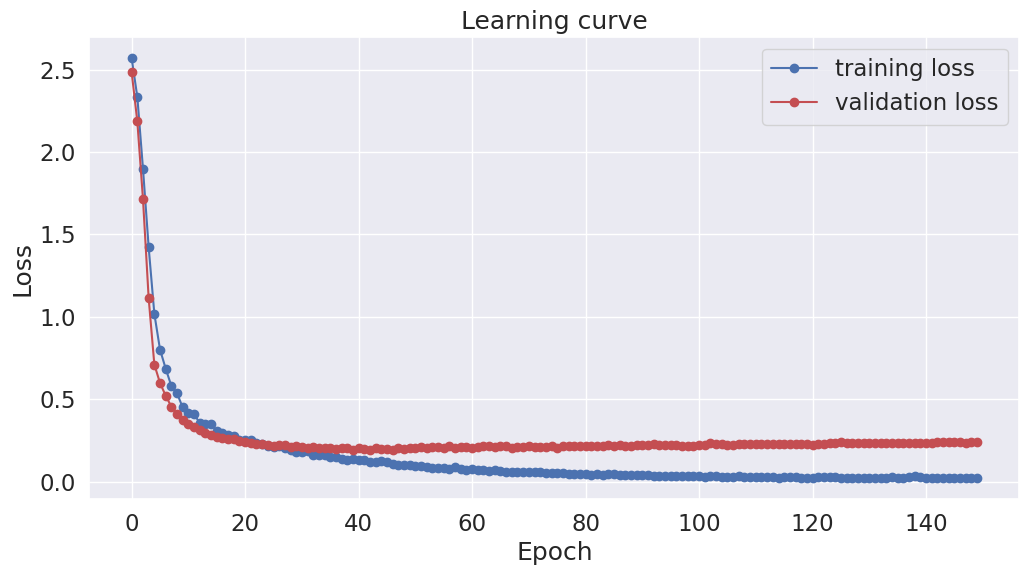

In [22]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Performance on test data

In [23]:
print(test_acc)

[2.4837438265482583, 2.18564772605896, 1.712647835413615, 1.1120134790738423, 0.7102320591608683, 0.5983279347419739, 0.5211707651615143, 0.45453078548113507, 0.4099598328272502, 0.3763286719719569, 0.3521505494912465, 0.3285818099975586, 0.3118108759323756, 0.2950112372636795, 0.2843092729647954, 0.27333658436934155, 0.26667584975560504, 0.25992659231026966, 0.25670064489046734, 0.2466250086824099, 0.23815766225258508, 0.23514583458503088, 0.23091437170902887, 0.22790576765934625, 0.22360478093226752, 0.21607442696889242, 0.2199520394206047, 0.219886414706707, 0.21269793808460236, 0.21327281246582666, 0.2098736191789309, 0.20529203365246454, 0.20766281833251318, 0.20182796319325766, 0.20148521413405737, 0.20352348188559213, 0.19829141100247702, 0.20534949253002802, 0.20251909146706262, 0.19190985833605131, 0.20330577964584032, 0.19696017603079477, 0.19281881426771483, 0.20388724903265634, 0.19849182044466337, 0.19953880086541176, 0.1935324321190516, 0.20196696246663728, 0.200620293617

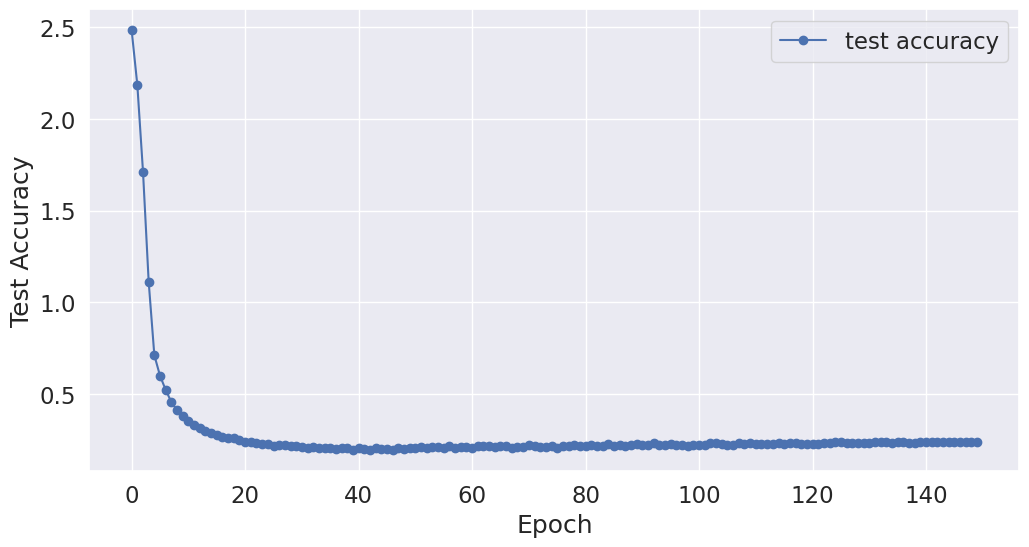

In [24]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(test_acc, 'b-o', label="test accuracy")


# Label the plot.
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.legend()

plt.show()

In [32]:

print(acc(False, 94))
acc(True, 94)


94 0.9529411764705882
0.7892861188668224
___________________0___________________

Predict labels:  ['0', '0', 'R', 'R', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', 'C', 'C', 'C', 'C-cont', 'C-cont', 'C-cont', 'C-cont', '0', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', 'C', 'C', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0']
Actual labels: 

___________________26___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C', '0', 'C', 'C', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', '0', 'C', 'C', 'C', '0', 'M', 'M', '0', 'C', 'C', 'C', '0', 'C', 'C', 'C', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C', '0', 'C', 'C', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', '0', 'C', 'C', 'C', '0', 'M', 'M-cont', '0', 'C', 'C', 'C', '0', 'C', 'C', 'C', '0', '0', '0']


___________________27___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', 'M', '0', 'M', '0', 'M', '0', 'M', 'M', '0', 'M', '0', '

___________________54___________________

Predict labels:  ['0', 'M', 'M', 'M', 'M', 'M', '0', '0', '0', '0', 'A', 'A', '0', '0', '0', '0', '0', 'A', 'A', 'A-cont', '0', '0', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q-cont', '0', '0', '0', '0', 'M', 'M', 'M', 'M', '0', 'M', 'M', 'M', 'M', '0', '0', '0', 'M', 'M', 'M', '0', '0', '0', '0', '0', 'A', 'A', 'A-cont', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'A', 'A', 'A-cont', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'A', 'A', 'A']
Actual labels:  ['0', '0', 'M', 'M', 'M', 'M', 'M', '0', '0', '0', '0', 'A', 'A', '0', '0', '0', '0', '0', 'A', 'A', 'A-cont', '0', '0', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q-cont', '0', '0', '0', '0', 'M', 'M', 'M', 'M', '0', 'M', 'M', 'M', 'M', '0', '0', '0', 'M', 'M', 'M', '0', '0', '0', '0', '0', 'A', 'A', 'A-cont', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'A', 'A', 'A-cont', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'A', 'A', 'A', '0']


_

___________________81___________________

Predict labels:  ['0', '0', '0', '0', '0', 'M', 'M', 'M', '0', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', 'A', 'A', 'A', 'A', 'A', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', 'M', '0', 'M', '0', '0', '0', '0', 'Q', '0', '0', 'C', 'C', 'C', '0', 'A', 'A', 'A-cont', 'A-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', 'M', '0', 'A', 'A', 'A', 'A-cont', 'A-cont', 'A-cont', '0', '0', '0', '0', 'A', 'A', 'A-cont', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', 'M', 'M', 'M', '0', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', 'A', 'A', 'A', 'A', 'A', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', 'M', '0', 'M', '0', '0', '0', '0', 'Q', '0', '0', 'C', 'C', 'C'

___________________108___________________

Predict labels:  ['0', '0', '0', '0', '0', 'A', 'A', 'A', 'A', '0', 'A', 'A', 'A', 'A', '0', '0', '0', '0', 'A', 'A', 'A', 'A', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'A', 'A', 'A-cont', '0', '0', '0', '0', 'M', 'M', 'M', 'M', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', '0', 'M', 'M', '0', '0', 'M', 'M', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', 'M', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', 'A', 'A', 'A', 'A', '0', 'A', 'A', 'A', 'A', '0', '0', '0', '0', 'A', 'A', 'A', 'A', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'A', 'A', 'A-cont', '0', '0', '0', '0', 'M', 'M', 'M', 'M', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', '0', 'M', 'M', '0', '0', 'M', 'M', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', 'M

___________________135___________________

Predict labels:  ['M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', '0', 'Q', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', 'M', 'M', '0', '0', 'M', 'M', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', 'R', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', 'R', 'R',

___________________161___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0']


94 0.9529411764705882


0.7892861188668224

In [26]:
print(acc(False, 112))

0.7892861188668224


In [27]:
model = torch.load("test.ck")
model.eval()

print(acc(False))
print(acc(True))

EOFError: Ran out of input